In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from tensorflow import keras
import keras_tuner as kt

In [3]:
def Sliding_Window(df_temp,win_len,stride):
    X=[]
    Y=[]
    T=[]

    for i in np.arange(0,len(df_temp)-(win_len),stride):
        temp = df_temp.iloc[i:i+win_len,[3,4]].values

        X.append(temp)
        Y.append(df_temp.iloc[i+win_len,-1])
        T.append(df_temp.iloc[i+win_len,0])

    return np.array(X),np.array(Y),np.array(T)

- The data imported from the Matlab-simulink model are in **csv format**, with name as "{Fault}_noise_02.csv"
- **M** number of such files are present, coresponding to **M** faults.
- In each fault file, the fault is introduced at **t=\[1000,1500\]s** for incipient fault and **t=\[2000,2500\]s** for the step fault.

The Goal is to extract only the values of residuals between t=\[1000,1500\]s and t=\[2000,2500\]s. These values are then stored in a **new DataFrame**, which contains the residual information for all the fault classes. 

In [4]:
working_cond = 40

Path = r'.\ALL_DC_motor_Data\Ua_{}V_Noise_2_perct'.format(working_cond) # Path of the folder containing CSV files from that working condition
file_name = os.listdir(path=Path) 

In [5]:
def PreprocessData(working_cond,win_len,stride):
    Path = r'.\ALL_DC_motor_Data\Ua_{}V_Noise_2_perct'.format(working_cond) # Path of the folder containing CSV files from that working condition
    file_name = os.listdir(path=Path) 


    X_full, Y_full = [], []

    for f in file_name : #Iterate through each file, which coresponds to a Fault
        csv_path =  os.path.join(Path,f)
        df = pd.read_csv(csv_path)

        temp_df_1=df[(df.time > 1050) & (df.time< 1500)]  # Incipient-Taking samples after which the Parameter fault was introduced

        x1, y1, _ = Sliding_Window(temp_df_1,win_len,stride)

        temp_df_2=df[(df.time > 2050) & (df.time< 2500)]  # Step -Taking samples after which the Parameter fault was introduced

        x2, y2, _ = Sliding_Window(temp_df_2,win_len,stride)

        x_temp, y_temp = np.concatenate((x1,x2),axis=0),np.concatenate((y1,y2),axis=0)

        X_full.append(x_temp)
        Y_full.append(y_temp)


    X_full = np.array(X_full)
    X_full = np.reshape(X_full, (-1,X_full.shape[2],X_full.shape[3]))

    Y_full = np.array(Y_full)
    Y_full = np.reshape(Y_full, (-1))

    return X_full, Y_full


In [6]:
WL=20
S=40

X_120, Y_120 = PreprocessData(working_cond=120,win_len=WL,stride=S)
X_80, Y_80  = PreprocessData(working_cond=80,win_len=WL,stride=S)
X_40, Y_40 = PreprocessData(working_cond=40,win_len=WL,stride=S)

In [7]:
X_full = np.concatenate((X_40,X_80,X_120))
Y_full = np.concatenate((Y_40,Y_80,Y_120))

print(f"length of total data = {len(X_full)}")

length of total data = 5376


In [8]:
fault_label_dict = {'Healthy':0, 'Re':1, 'Rm':2, 'I':3, 'W':4, 'K':5,  'Re & Rm':6, 'I & W':7}

Y_full = np.vectorize(fault_label_dict.get)(Y_full)

## Resample the Data

In [9]:
def n_samples_per_class(X_sc,Y,num_samples):
    from sklearn.utils import resample
    if len(X_sc.shape)==3:
        # Initialize empty arrays for the sampled data
        x_sample = np.zeros((num_samples * np.unique(Y).size, X_sc.shape[1], X_sc.shape[2]))
    else:
        x_sample = np.zeros((num_samples * np.unique(Y).size, X_sc.shape[1]))
    y_sample = np.zeros(num_samples * np.unique(Y).size)

    # Loop over each class label and sample from the corresponding data points
    for i, label in enumerate(np.unique(Y)):
        class_indices = np.where(Y == label)[0]
        sampled_indices = resample(class_indices, n_samples=num_samples, replace=False, random_state=0)
        x_sample[i*num_samples:(i+1)*num_samples] = X_sc[sampled_indices]
        y_sample[i*num_samples:(i+1)*num_samples] = Y[sampled_indices]

    return x_sample,y_sample

In [10]:
def Scale_Encode(X_full,Y_full, num_training_samples):
    # Train Test split
    X_train,y_train=n_samples_per_class(X_full,Y_full,num_samples=num_training_samples)
    X_test,y_test = X_full, Y_full

    # Standardising the data
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sc = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    # One Hot encoding
    encoder = OneHotEncoder(sparse=False)
    y_train_ohe = encoder.fit_transform(y_train.reshape(-1,1))
    y_test_ohe = encoder.transform(y_test.reshape(-1,1))

    return X_train_sc, X_test_sc, y_train_ohe, y_test_ohe, scaler, encoder

# Hyper Parameter Tuning

In [11]:
def CNN_model(encoder,X_train_transformed):
    from tensorflow.keras.models import Sequential,Model
    from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
    from tensorflow.keras.layers import Conv1D, MaxPooling1D

    # Hyperparameters obtained aftre tuning
    num_k1=112
    k1 = 5
    num_d1=96
    alpha = 0.001

    num_classes=len(encoder.categories_[0])

    cnn_model = Sequential()
    cnn_model.add(Conv1D(num_k1, kernel_size=(k1),activation='relu',input_shape=(X_train_transformed.shape[1],X_train_transformed.shape[2]),padding='same'))
    cnn_model.add(MaxPooling1D((2),padding='same'))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(num_d1, activation='relu'))
    cnn_model.add(Dense(num_classes, activation='sigmoid'))

    cnn_model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=alpha),metrics=['accuracy'])
    
    return cnn_model

# AI Training

# number of samples Vs F1 score

In [12]:
from sklearn.metrics import f1_score
import tensorflow

f1 = []

for N in [1,2,4,8,16,32,64,100,128]:
    print(f'Experiment for N = {N}')
    X_train_sc, X_test_sc, y_train_ohe, y_test_ohe, scaler, encoder = Scale_Encode(X_full,Y_full, num_training_samples=N)
    cnn_model=CNN_model(encoder,X_train_sc)
    callback = tensorflow.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10,restore_best_weights=True)
    cnn_model.fit(X_train_sc,
                y_train_ohe,
                epochs=200,
                batch_size=int(0.1*len(X_train_sc)),              
                callbacks=[callback],
                shuffle=True,verbose=0)

    y_pred=cnn_model.predict(X_test_sc)
    y_pred=encoder.inverse_transform(y_pred)
    y_test = encoder.inverse_transform(y_test_ohe)

    f1.append(f1_score(y_test,y_pred,average='micro'))


Experiment for N = 1
Experiment for N = 2
Experiment for N = 4
Experiment for N = 8
Experiment for N = 16
Experiment for N = 32
Experiment for N = 64
Experiment for N = 100
Experiment for N = 128


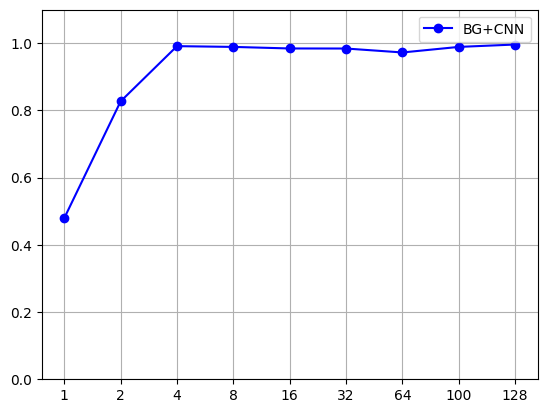

In [70]:
plt.plot([str(x) for x in [1,2,4,8,16,32,64,100,128]],f1,'bo-')
plt.ylim([0,1.1])
plt.grid(visible=True)
plt.legend(['BG+CNN'])
plt.show()

# PCA-visualization after training with N-8

In [20]:
X_train_sc, X_test_sc, y_train_ohe, y_test_ohe, scaler, encoder = Scale_Encode(X_full,Y_full, num_training_samples=8)
y_train, y_test = encoder.inverse_transform(y_train_ohe), encoder.inverse_transform(y_test_ohe)
cnn_model=CNN_model(encoder,X_train_sc)
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10,restore_best_weights=True)
cnn_model.fit(X_train_sc,
            y_train_ohe,
            epochs=200,
            batch_size=int(0.1*len(X_train_sc)),              
            callbacks=[callback],
            shuffle=True,verbose=0)

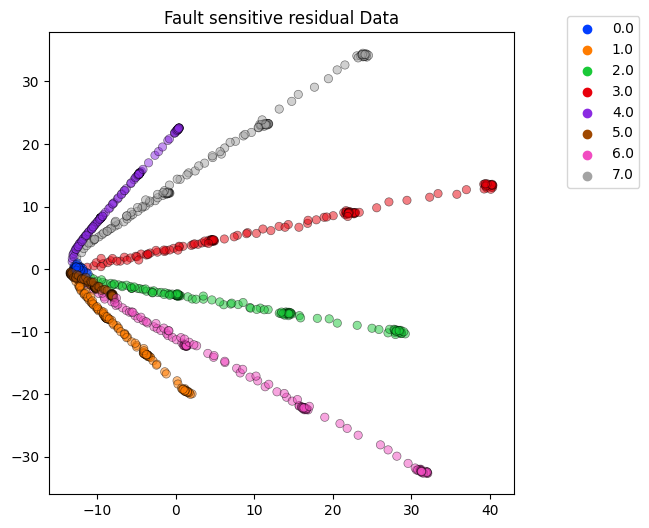

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.models import Sequential,Model

projection_2d = Model(cnn_model.layers[0].input, cnn_model.layers[-2].output)

embd = projection_2d.predict(X_test_sc)

pca = PCA(n_components=2)
x_test_embd = pca.fit_transform(embd)


f, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(x=x_test_embd[::5,0], y=x_test_embd[::5,1] , hue=y_test[::5].reshape(-1),palette="bright",edgecolor='black',alpha=0.5 )
plt.title('Fault sensitive residual Data')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()